In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import json
import joblib

In [2]:
# Load the training data
train_data = pd.read_csv('kddcup.data.gz', header=None)
test_data = pd.read_csv('kddcup.testdata.unlabeled.gz', header=None)

In [3]:
# Load the feature names and attack types
with open('kddcup.names.txt', 'r') as f:
    feature_names = [line.strip() for line in f.readlines() if not line.startswith('|') and line.strip()][1:]

with open('training_attack_types.txt', 'r') as f:
    attack_types = dict(line.strip().split() for line in f.readlines())


In [4]:
# remove feature type from feature names
feature_names = [name.split(':')[0] for name in feature_names]
# add target feature as our predict column
feature_names.append('target')

In [5]:
# set columns for train and test dataframes
train_data.columns = feature_names
test_data.columns = feature_names[:-1] # test data wont have taget column so removing last column

In [6]:
# prepare attact types data map

# add normal attack type
attack_types['normal'] = 'normal'
# remove periods from targert names
train_data['target'] = train_data['target'].str.rstrip('.')

In [7]:
train_data['target'] = train_data['target'].map(attack_types)

In [8]:
# identifiy categorical data
{k:v for k,v in train_data.dtypes.items() if v == 'object'}

{'protocol_type': dtype('O'),
 'service': dtype('O'),
 'flag': dtype('O'),
 'target': dtype('O')}

In [9]:
# prepare encoding data map for categorical data
protocol_type_map = {v:i for i,v in enumerate(train_data['protocol_type'].unique())}
service_map = {v:i for i,v in enumerate(train_data['service'].unique())}
flag_map = {v:i for i,v in enumerate(train_data['flag'].unique())}
target_map = {v:i for i,v in enumerate(train_data['target'].unique())}

In [10]:
# Combine all maps into a single dictionary
encoding_maps = {
    'protocol_type_map': protocol_type_map,
    'service_map': service_map,
    'flag_map': flag_map,
    'target_map': target_map
}

# Write the dictionary to a JSON file
file_path = 'encoding_maps.json'
with open(file_path, 'w') as json_file:
    json.dump(encoding_maps, json_file, indent=4)

In [11]:
# check na data for train 
{k:v for k,v in train_data.isna().sum().items() if v!= 0}

{}

In [12]:
# check na data for test 
{k:v for k,v in test_data.isna().sum().items() if v!= 0}

{}

In [13]:
# remove na value rows from test data
train_data.dropna(inplace=True)
test_data.dropna(inplace=True)


In [14]:
# count, mean, std, min, q1, q2, q3, max
train_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,...,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,...,2.329811e+02,1.892142e+02,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,...,6.402094e+01,1.059128e+02,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,2.550000e+02,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


<Axes: xlabel='protocol_type'>

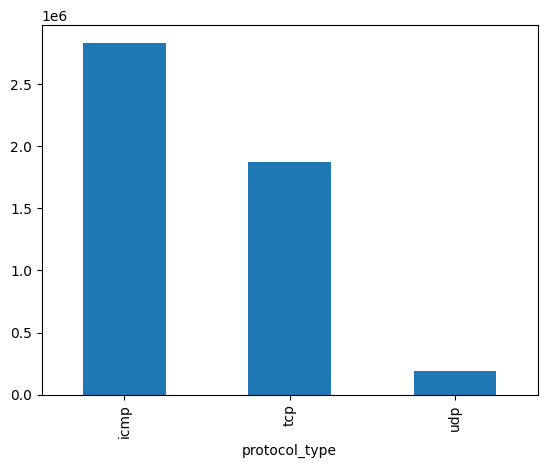

In [15]:
train_data['protocol_type'].value_counts().plot(kind="bar")

<Axes: xlabel='service'>

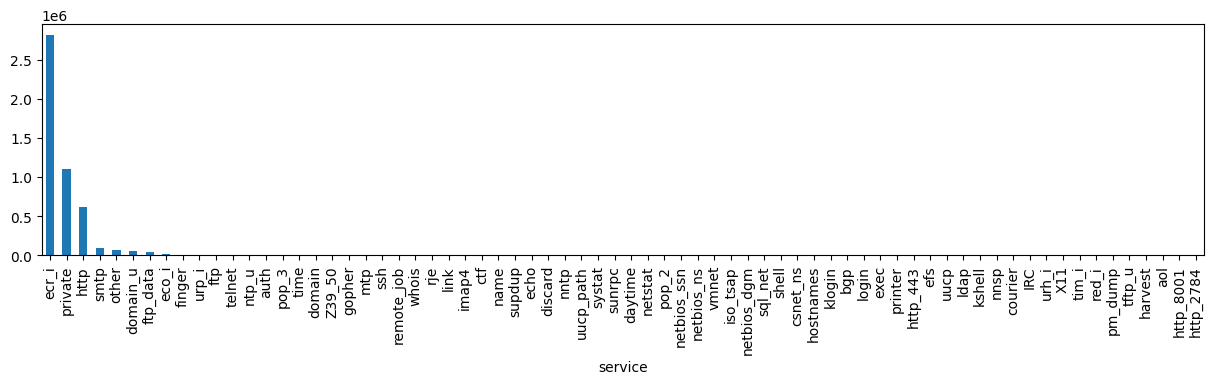

In [16]:
plt.figure(figsize=(15,3))
train_data['service'].value_counts().plot(kind="bar")

<Axes: xlabel='flag'>

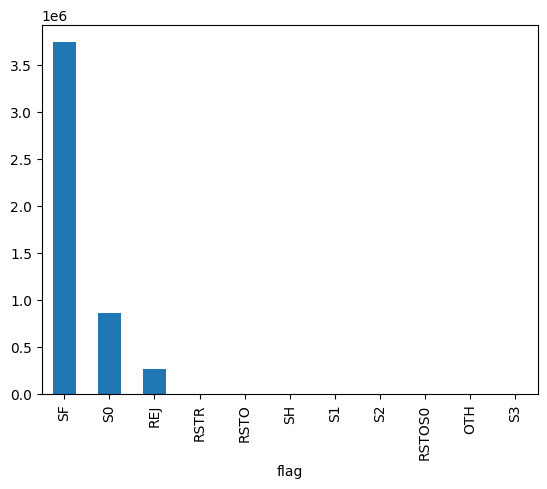

In [17]:
train_data['flag'].value_counts().plot(kind="bar")

In [18]:
# enocode all the categorical features for train and test data
train_data['target'] = train_data['target'].map(target_map)
train_data['protocol_type'] = train_data['protocol_type'].map(protocol_type_map)
train_data['service'] = train_data['service'].map(service_map)
train_data['flag'] = train_data['flag'].map(flag_map)

test_data['protocol_type'] = test_data['protocol_type'].map(protocol_type_map)
test_data['service'] = test_data['service'].map(service_map)
test_data['flag'] = test_data['flag'].map(flag_map)

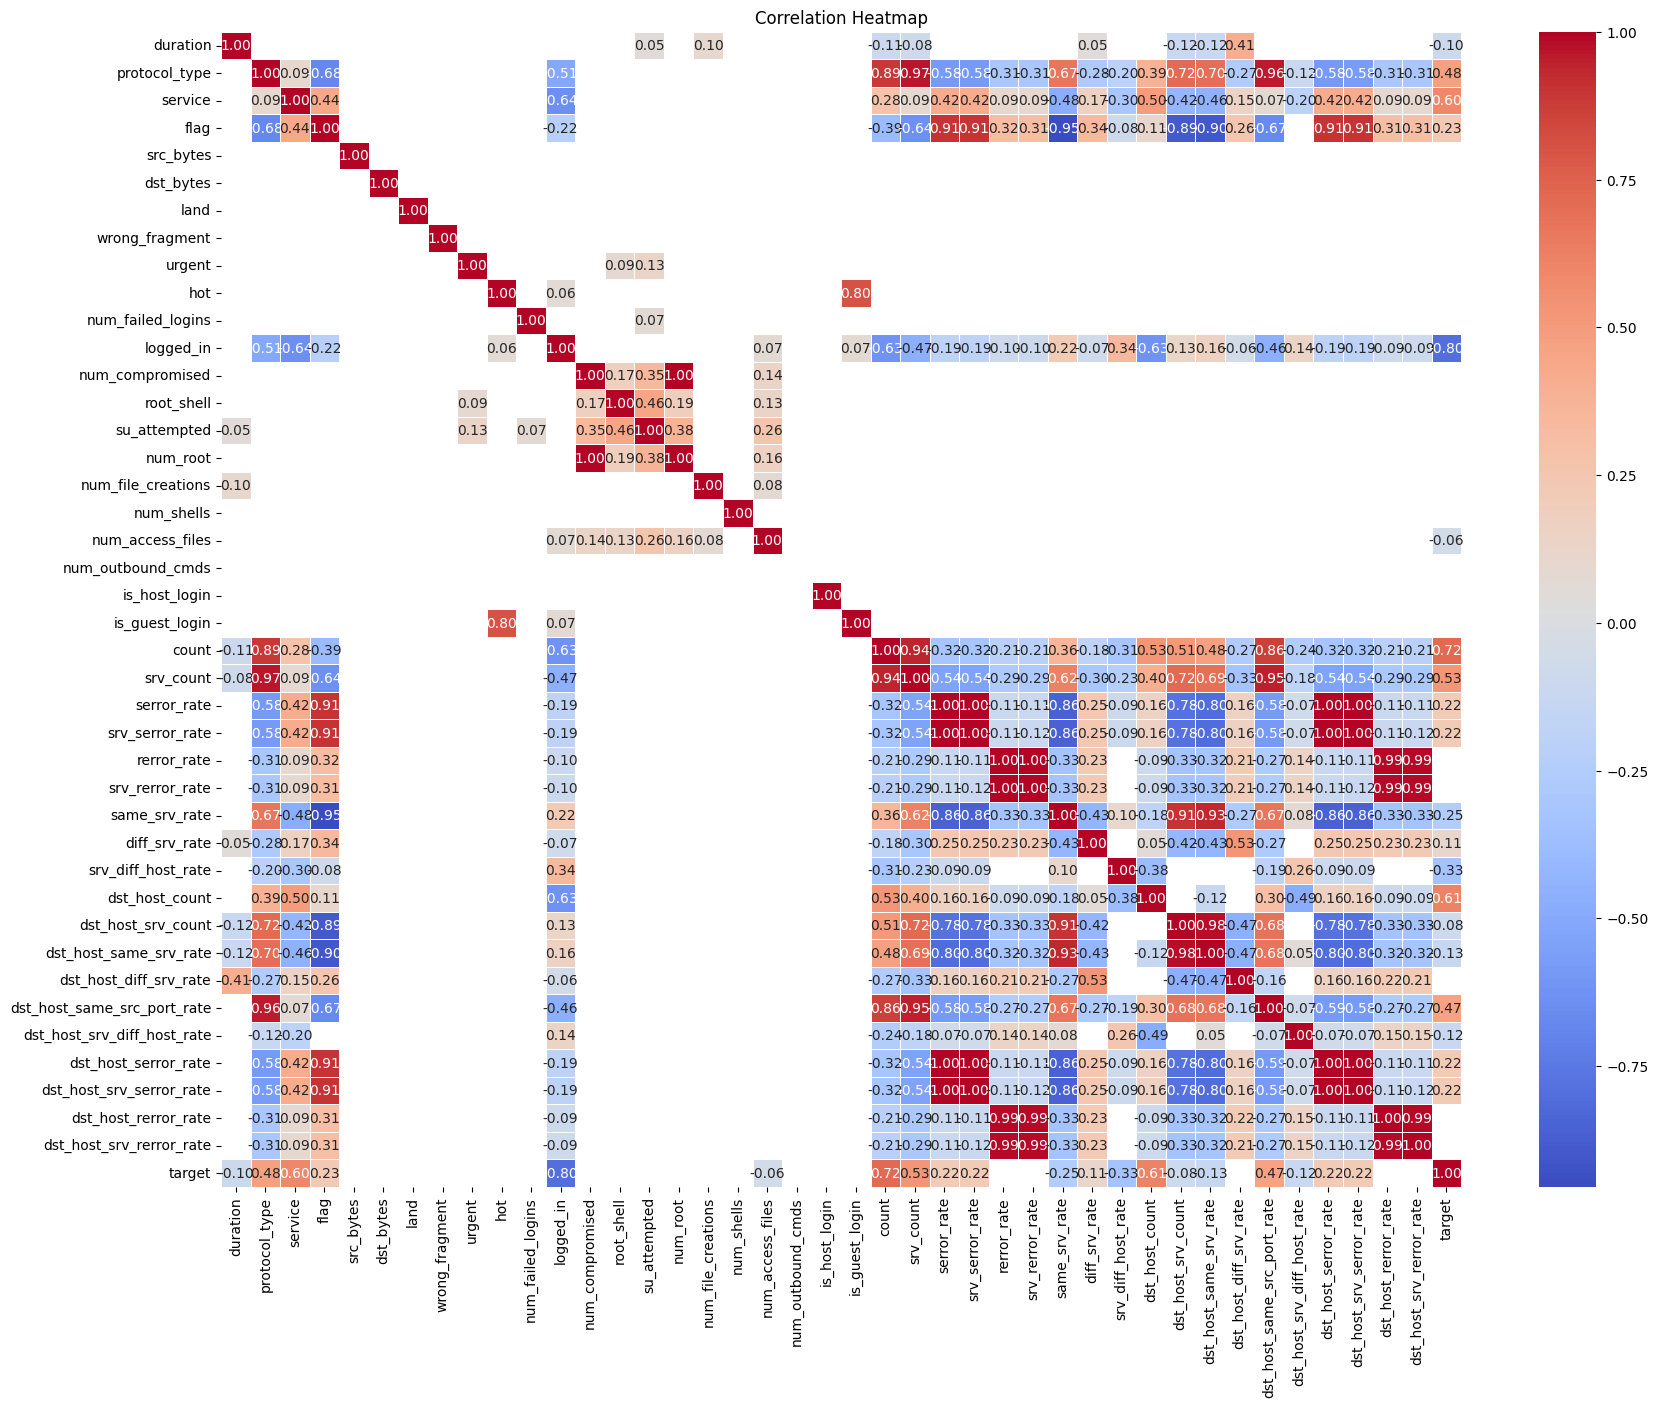

In [19]:
# Correlation heatmap
plt.figure(figsize=(4*5, 3*5))
corr_matrix = train_data.corr()
significant_corr_matrix = corr_matrix[(corr_matrix > 0.05) | (corr_matrix < -0.05)]
sns.heatmap(significant_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [20]:
"""
Drops highly correlated features to reduce redundancy and multicollinearity:

- num_root (correlated with num_compromised)
- srv_serror_rate (correlated with serror_rate)
- srv_rerror_rate (correlated with rerror_rate)
- dst_host_srv_serror_rate (correlated with srv_serror_rate)
- dst_host_serror_rate (correlated with rerror_rate)
- dst_host_rerror_rate (correlated with srv_rerror_rate)
- dst_host_srv_rerror_rate (correlated with rerror_rate)
- dst_host_same_srv_rate (correlated with dst_host_srv_count)
"""
drop_corr = ['num_root','srv_serror_rate','srv_rerror_rate','dst_host_srv_serror_rate','dst_host_serror_rate','dst_host_srv_rerror_rate','dst_host_same_srv_rate','dst_host_rerror_rate']

In [21]:

# Write the dictionary to a JSON file
file_path = 'drop_columns.json'
with open(file_path, 'w') as json_file:
    json.dump(drop_corr, json_file, indent=4)

In [22]:
train_data = train_data.drop(drop_corr, axis=1)
test_data = test_data.drop(drop_corr, axis=1)

In [23]:

# Target variable and train set
X = train_data.drop('target', axis=1)
Y = train_data['target']



In [24]:
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [25]:

# Split the training data into training and validation sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [30]:
Y_train.value_counts()

target
2    3106862
0     778092
4      32848
3        902
1         40
Name: count, dtype: int64

In [26]:
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(3918744, 33) (979687, 33)
(3918744,) (979687,)


In [27]:
X

array([[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.5 , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.2 , 0.05],
       [0.  , 0.  , 0.  , ..., 0.  , 0.17, 0.05],
       [0.  , 0.  , 0.  , ..., 0.  , 0.14, 0.05]])

In [28]:
# Define file paths
X_train_path = 'train_test_data/X_train.pkl'
X_test_path = 'train_test_data/X_test.pkl'
Y_train_path = 'train_test_data/Y_train.pkl'
Y_test_path = 'train_test_data/Y_test.pkl'

# Save the split data to files
joblib.dump(X_train, X_train_path)
joblib.dump(X_test, X_test_path)
joblib.dump(Y_train, Y_train_path)
joblib.dump(Y_test, Y_test_path)

print("Training and validation sets have been saved to files.")


Training and validation sets have been saved to files.
